# Several code snippets for the pizza project

The data can be downloaded from the page: http://pizzagan.csail.mit.edu/

There are two types of data: synthetic and real. Use the dataset you want, but beware that they do not have the same labels. They were not originally used for label prediction.



## Path setup for data and networks

In [1]:
# from google.colab import drive

# drive.mount('/content/gdrive/')

DATA_DIR =  '../Dataset-Pizza'


## Useful libraries

In [3]:
import pandas as pd
import numpy as np
import os
import time
import matplotlib.pyplot as plt
from PIL import Image

from tqdm import tqdm

import seaborn as sns
sns.set_style('darkgrid')

#import shutil

import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

# scikitlearn
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split

# Pytorch
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision
import torchvision.transforms as transforms
from torchvision import models
import torch.optim as optim
# from torch.optim import lr_scheduler
import torch.nn.functional as F
import torch.nn as nn


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# verify that the installed cuda version is anterior (or equal) to the cuda version of !nvidia-smi 
# print(torch.version.cuda)

if (torch.cuda.is_available()):
  !nvidia-smi

11.7
Tue Jan 24 18:11:58 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
| N/A   47C    P8     2W /  N/A |    354MiB /  3914MiB |     18%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+--

## Managing data

### Download dataset and unzip the archive
Uncomment the following lines to do it.

In [4]:
#!cd /content/gdrive/MyDrive/Colab\ Notebooks/Projet\ MI201/

#!ls

#!wget http://pizzagan.csail.mit.edu/pizzaGANsyntheticdata.zip

# !unzip '/content/gdrive/MyDrive/Colab Notebooks/Projet MI201/pizzaGANsyntheticdata' -d '/content/gdrive/MyDrive/Colab Notebooks/Projet MI201'

### Read data

and build the train and test dataset

In [5]:
y_all = np.loadtxt(os.path.join(DATA_DIR, 'syntheticDataset/train/trainLabels.txt'))
x_all = np.arange(y_all.shape[0])

# Create train, val and test splits
# x_train and x_val only contain image number (not the raw data)

x_train, x_val, y_train, y_val = train_test_split(x_all, y_all, test_size=0.2, random_state=123)

print(y_train.shape)

y_test = np.loadtxt(os.path.join(DATA_DIR, 'syntheticDataset/test/testLabels.txt'))
x_test = np.arange(y_test.shape[0])

print(y_test.shape)


(3976, 10)
(497, 10)


### Display one sample image

0046.png


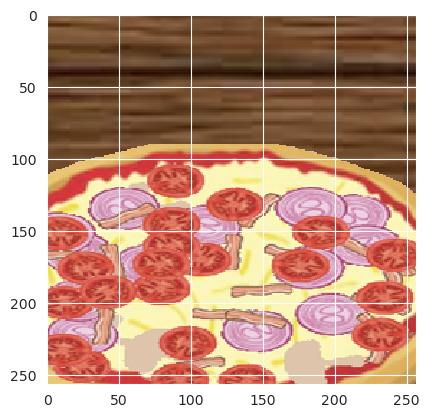

In [6]:
idx = 45

img_name = "{:04d}.png".format(idx+1)
print(img_name)

img_path = os.path.join(DATA_DIR, 'syntheticDataset/train/images')

img = Image.open(os.path.join(img_path, img_name))

plt.imshow(img)
plt.show()

### Store train images in memory

This should make learning faster.

In [7]:
train_data_path=os.path.join(DATA_DIR, 'syntheticDataset/train')

# Test if the numpy file exists
if (os.path.exists(os.path.join(train_data_path, 'img_data_224.npz'))):
  img_data_tensor = np.load(os.path.join(train_data_path, 'img_data_224.npz'))
  img_all = img_data_tensor['img_data']
else:
  img_all = []

  for idx in tqdm(x_all):
      img_name = "{:04d}.png".format(idx+1)
      x = Image.open(os.path.join(train_data_path, 'images', img_name))
      img_all.append(np.array(x.resize((224,224))))

  np.savez_compressed(os.path.join(train_data_path,'img_data_224.npz'), img_data=np.array(img_all))

### Dataset class

In [8]:
class myDataset(Dataset):
    """Pizza dataset"""
    
    def __init__(self, x_idx, y, img_path='/content/gdrive/MyDrive/Colab Notebooks/syntheticDataset/train/images', img_data = None, transform=None):
      """
      Args:
      """
      self.x_idx = x_idx
      self.y = y
      self.img_path = img_path
      self.transform = transform
      self.img_data = img_data     
    
    def __getitem__(self, idx):
      if isinstance(self.img_data,np.ndarray):
        x = Image.fromarray(self.img_data[idx,:,:,:])
      else:
        img_name = "{:04d}.png".format(idx+1)
        x = Image.open(os.path.join(self.img_path, img_name))
      y = self.y[idx,:]
      if self.transform:
          x = self.transform(x)
      y = np.int64(y)
      return x, y
            
    def __len__(self):
        return int(len(self.x_idx))


### Data loaders

In [9]:
batch_size = 25

# 224 for efficientNEt, 32 for simple CNN
# input_size = 224
input_size = 32

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

train_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                         transforms.RandomVerticalFlip(),
                                         transforms.ColorJitter(brightness=32. / 255., saturation=0.5),
                                         transforms.Resize(input_size),
                                         transforms.ToTensor(),
                                     normalize])

val_transform = transforms.Compose([transforms.Resize(input_size),
                                    transforms.ToTensor(),
                                   normalize])
        
kwargs = {'num_workers': 2, 'pin_memory': True} if torch.cuda.is_available() else {}

train_data_path=img_path = os.path.join(DATA_DIR, 'syntheticDataset/train/images')

img_data=np.array(img_all) # an error occured and we noticed that img_data=np.array(img_all) appeared in np.savez_compressed. hence our idea to add that line
img_data_train = img_data[x_train,:,:,:]
train_set_raw = myDataset(x_train, y_train, img_path=train_data_path, img_data=img_data_train, transform = train_transform)
train_dataloader = DataLoader(train_set_raw, batch_size=batch_size, shuffle=True, num_workers=2, **kwargs)

img_data_val = img_data[x_val,:,:,:]
val_set_raw = myDataset(x_val, y_val, img_path=train_data_path, img_data=img_data_val, transform = val_transform)
val_dataloader = DataLoader(val_set_raw, batch_size=batch_size, shuffle=False, num_workers=2, **kwargs)

test_data_path=img_path = os.path.join(DATA_DIR, 'syntheticDataset/test/images')

test_set_raw = myDataset(x_test, y_test, img_path=test_data_path, transform = val_transform)
test_dataloader = DataLoader(test_set_raw, batch_size=batch_size, shuffle=False, num_workers=2, **kwargs)


### Visualize data loader

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


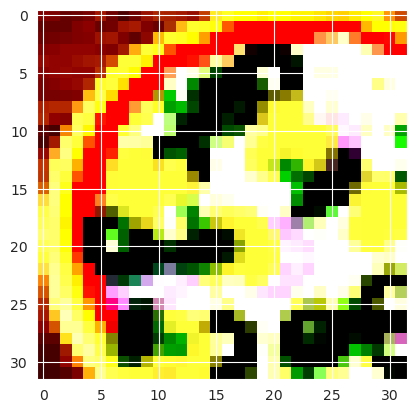

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([25, 3, 32, 32])


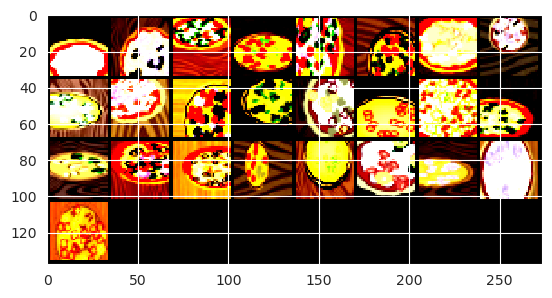

In [10]:
# Show dataset sample
x,y = test_set_raw[45]
#print(x,y)

plt.imshow(x.permute(1, 2, 0).numpy())
plt.show()

# Show batch of images
#it = iter(train_dataloader)
sample,labels = next(iter(train_dataloader))
print(sample.shape)

out = torchvision.utils.make_grid(sample)
plt.imshow(out.permute(1, 2, 0))


## Learning

There are several possibilities to solve the problem:

* Extract good features and apply a simple predictor. The problem is to find good features for the problem: you know what they can be and how to compute them, or you can rely on "generic" features like bag of visual words, histograms or deep features.

* Work on raw data and build the label predictor directly. This is typically an approach for deep learning.

Notice that the problem is **multi-label prediction**, not classification. Each image may be characterized by several labels.


### Simple network definition

An elementary convolutional network with input datasize of 32x32.

In order to try it, we had to modify the input_size and set it to 32.

In [11]:

# network class
class SimpleCNN(nn.Module):
# Network requires 32x32 input images  
  def __init__(self, nlabel = 10):
    super(SimpleCNN, self).__init__()
    self.nlabel = nlabel
    
    # define here the convolutions and linear layers
    self.conv1 = nn.Conv2d(3,16,3)
    self.conv2 = nn.Conv2d(16,32,3)
    self.conv3 = nn.Conv2d(32,64,3)
    self.lin1 = nn.Linear(256, 128)
    self.lin2 = nn.Linear(128, self.nlabel)
    
  def forward(self, x):
    
    # 32x32
    
    # define here the forward pass
    x1 = self.conv1(x)
    x1r = F.relu(x1)
    x1p = F.max_pool2d(x1r, 2)
    
    # 16x16
    x2 = self.conv2(x1p)
    x2r = F.relu(x2)
    x2p = F.max_pool2d(x2r, 2)
    
    # 8x8
    x3 = self.conv3(x2p)
    x3r = F.relu(x3)
    x3p = F.max_pool2d(x3r, 2)
    
    # 4x4
    y0 = x3p.view(x3p.size(0), -1)
    y1 = self.lin1(y0)
    y1r = F.relu(y1)
    y2 = self.lin2(y1r)
    
    return y2
    

### Another more complex network

From torchvision.

In [12]:
nlabel = y_all.shape[1]

from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

# tag = "efficientNet"
tag = "simpleCNN"

if tag=='efficientNet':
  network = torchvision.models.efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT)
  num_ftrs = network.classifier[1].in_features
  network.classifier[1]= nn.Linear(num_ftrs, nlabel)

elif tag=='simpleCNN':
  # network = SimpleCNN(nlabel = nlabel)
  net_path = "Networks/network_"+tag+".pth"
  print(net_path)
  network = torch.load(net_path)
  print("simpleCNN")

print(network)


Networks/network_simpleCNN.pth
simpleCNN
SimpleCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (lin1): Linear(in_features=256, out_features=128, bias=True)
  (lin2): Linear(in_features=128, out_features=10, bias=True)
)


## Learning

Generic function for multi-label learning.


In [14]:
from IPython.display import clear_output

import copy
import random

testloader = test_dataloader

def train_model_multilabel(model, nlabel, trainloader, valloader, criterion, optimizer, scheduler, num_epochs=5):
  # list for saving accuracies
  train_perf = []
  test_perf = []
  train_losses = []

  # print(model)

  for epoch in range(num_epochs):
      print("Epoch {}".format(epoch))
      model.train()
      for inputs, targets in trainloader:     ## on itere sur les données 
          # inputs is 25 RGB images
          # outputs is 25 targets
          inputs, targets = inputs.cuda(),targets.cuda()

          predictions = model(inputs)    ## on les fait rentrer dans le réseau
          targets = targets.to(torch.float) # FloatTensor needed

          loss = criterion(predictions,targets)    ## on compare la sortie courante à la sortie voulue
          optimizer.zero_grad() ## supprime les gradients courants
          loss.backward() ## le gradient -- la magie par rapport à comment c'était long en cours :-)
          optimizer.step() ## on actualise les poids pour que la sortie courante soit plus proche que la sortie voulue
          train_losses.append(loss)
          train_perf.append(accuracy_score(targets.cpu().numpy(), (predictions.cpu().detach().numpy() > 0.5)))
          if random.randint(0,90)==0:
              print("\tloss=",loss) ## on affiche pour valider que ça diverge pas

  # y_pred et y_true

  model.eval()
  with torch.no_grad():  ### ici pas besoin de calculer les gradients
      for inputs, targets in testloader:
          inputs = inputs.cuda()
          outputs = model(inputs)
          test_perf.append(accuracy_score(targets.cpu().numpy(), (outputs.cpu().numpy() > 0.5)))

  # beep noise when training finished
  !echo -e '\a'
        
# Learning step
  return model, train_perf, test_perf, train_losses




     



### Example of a code calling the learning function

TODO : Replace it with the overnight training script ?

In [ ]:
# Define data loaders
trainloader=train_dataloader
valloader=val_dataloader

network_path = "Networks"
# Read the last learned network (if stored)
if (os.path.exists(os.path.join(network_path, 'network_{:s}.pth'.format(tag)))):
    print('Resume from last learning step')
    network = torch.load(os.path.join(img_path, 'network_{:s}.pth'.format(tag)))

# Transfer network to GPU
network.to(device)

# Define learning components (to be used in the learning function)

optimizer = optim.Adam(network.parameters(), lr=0.00001)
criterion = nn.CrossEntropyLoss()
scheduler = None

# Learning 

max_epoch = 500 # initial 20
learned_model, train_error, test_error, train_losses = train_model_multilabel(network, nlabel, trainloader, valloader, criterion, optimizer, scheduler, num_epochs=max_epoch)

torch.save(learned_model, os.path.join(network_path, 'network_{:s}.pth'.format(tag)))

network = learned_model

print("Train accuracies")
print(train_error)
print("Test accuracies")
print(test_error)
# print("Train losses")
# print(train_losses)



Resume from last learning step
Epoch 0
	loss= tensor(6.5272, device='cuda:0', grad_fn=<DivBackward1>)
Epoch 1
	loss= tensor(6.5281, device='cuda:0', grad_fn=<DivBackward1>)
Epoch 2
	loss= tensor(5.5020, device='cuda:0', grad_fn=<DivBackward1>)
	loss= tensor(5.9984, device='cuda:0', grad_fn=<DivBackward1>)
Epoch 3
	loss= tensor(7.3373, device='cuda:0', grad_fn=<DivBackward1>)
Epoch 4
Epoch 5
	loss= tensor(6.0587, device='cuda:0', grad_fn=<DivBackward1>)
	loss= tensor(6.9751, device='cuda:0', grad_fn=<DivBackward1>)
	loss= tensor(5.4817, device='cuda:0', grad_fn=<DivBackward1>)
	loss= tensor(6.0259, device='cuda:0', grad_fn=<DivBackward1>)
Epoch 6
	loss= tensor(6.7012, device='cuda:0', grad_fn=<DivBackward1>)
Epoch 7
	loss= tensor(7.6294, device='cuda:0', grad_fn=<DivBackward1>)
	loss= tensor(5.7977, device='cuda:0', grad_fn=<DivBackward1>)
	loss= tensor(6.4749, device='cuda:0', grad_fn=<DivBackward1>)
Epoch 8
	loss= tensor(6.4766, device='cuda:0', grad_fn=<DivBackward1>)
	loss= tensor(6

	loss= tensor(5.7342, device='cuda:0', grad_fn=<DivBackward1>)
Epoch 81
	loss= tensor(5.7827, device='cuda:0', grad_fn=<DivBackward1>)
	loss= tensor(6.1468, device='cuda:0', grad_fn=<DivBackward1>)
	loss= tensor(6.5233, device='cuda:0', grad_fn=<DivBackward1>)
	loss= tensor(6.1919, device='cuda:0', grad_fn=<DivBackward1>)
Epoch 82
	loss= tensor(7.1872, device='cuda:0', grad_fn=<DivBackward1>)
	loss= tensor(5.7555, device='cuda:0', grad_fn=<DivBackward1>)
	loss= tensor(6.2976, device='cuda:0', grad_fn=<DivBackward1>)
Epoch 83
	loss= tensor(6.2147, device='cuda:0', grad_fn=<DivBackward1>)
	loss= tensor(5.6932, device='cuda:0', grad_fn=<DivBackward1>)
Epoch 84
	loss= tensor(6.4440, device='cuda:0', grad_fn=<DivBackward1>)
Epoch 85
	loss= tensor(7.4625, device='cuda:0', grad_fn=<DivBackward1>)
Epoch 86
	loss= tensor(6.3218, device='cuda:0', grad_fn=<DivBackward1>)
Epoch 87
	loss= tensor(6.4007, device='cuda:0', grad_fn=<DivBackward1>)
	loss= tensor(7.3209, device='cuda:0', grad_fn=<DivBack

Epoch 146
	loss= tensor(5.7645, device='cuda:0', grad_fn=<DivBackward1>)
	loss= tensor(4.6460, device='cuda:0', grad_fn=<DivBackward1>)
	loss= tensor(5.4605, device='cuda:0', grad_fn=<DivBackward1>)
	loss= tensor(8.4900, device='cuda:0', grad_fn=<DivBackward1>)
Epoch 147
	loss= tensor(6.2382, device='cuda:0', grad_fn=<DivBackward1>)
Epoch 148
	loss= tensor(6.4847, device='cuda:0', grad_fn=<DivBackward1>)
	loss= tensor(6.8148, device='cuda:0', grad_fn=<DivBackward1>)
	loss= tensor(6.4055, device='cuda:0', grad_fn=<DivBackward1>)
Epoch 149
	loss= tensor(7.1463, device='cuda:0', grad_fn=<DivBackward1>)
	loss= tensor(8.5613, device='cuda:0', grad_fn=<DivBackward1>)
Epoch 150
	loss= tensor(6.5694, device='cuda:0', grad_fn=<DivBackward1>)
Epoch 151
	loss= tensor(6.3425, device='cuda:0', grad_fn=<DivBackward1>)
	loss= tensor(6.0375, device='cuda:0', grad_fn=<DivBackward1>)
Epoch 152
	loss= tensor(5.6216, device='cuda:0', grad_fn=<DivBackward1>)
Epoch 153
	loss= tensor(7.3550, device='cuda:0',

Epoch 215
	loss= tensor(6.3457, device='cuda:0', grad_fn=<DivBackward1>)
	loss= tensor(6.8021, device='cuda:0', grad_fn=<DivBackward1>)
Epoch 216
	loss= tensor(5.6414, device='cuda:0', grad_fn=<DivBackward1>)
	loss= tensor(6.0719, device='cuda:0', grad_fn=<DivBackward1>)
	loss= tensor(6.2500, device='cuda:0', grad_fn=<DivBackward1>)
Epoch 217
	loss= tensor(6.6036, device='cuda:0', grad_fn=<DivBackward1>)
	loss= tensor(5.3751, device='cuda:0', grad_fn=<DivBackward1>)
	loss= tensor(5.8684, device='cuda:0', grad_fn=<DivBackward1>)
	loss= tensor(6.6877, device='cuda:0', grad_fn=<DivBackward1>)
Epoch 218
	loss= tensor(6.4682, device='cuda:0', grad_fn=<DivBackward1>)
	loss= tensor(6.1865, device='cuda:0', grad_fn=<DivBackward1>)
	loss= tensor(6.3123, device='cuda:0', grad_fn=<DivBackward1>)
Epoch 219
	loss= tensor(7.7360, device='cuda:0', grad_fn=<DivBackward1>)
Epoch 220
	loss= tensor(5.9184, device='cuda:0', grad_fn=<DivBackward1>)
Epoch 221
	loss= tensor(6.2269, device='cuda:0', grad_fn=<

	loss= tensor(6.1962, device='cuda:0', grad_fn=<DivBackward1>)
	loss= tensor(6.5257, device='cuda:0', grad_fn=<DivBackward1>)
	loss= tensor(5.9020, device='cuda:0', grad_fn=<DivBackward1>)
	loss= tensor(7.1018, device='cuda:0', grad_fn=<DivBackward1>)
Epoch 291
	loss= tensor(6.7093, device='cuda:0', grad_fn=<DivBackward1>)
	loss= tensor(7.0960, device='cuda:0', grad_fn=<DivBackward1>)
	loss= tensor(5.7654, device='cuda:0', grad_fn=<DivBackward1>)
Epoch 292
	loss= tensor(6.6858, device='cuda:0', grad_fn=<DivBackward1>)
Epoch 293
Epoch 294
	loss= tensor(5.6400, device='cuda:0', grad_fn=<DivBackward1>)
	loss= tensor(7.0216, device='cuda:0', grad_fn=<DivBackward1>)
	loss= tensor(6.7994, device='cuda:0', grad_fn=<DivBackward1>)
	loss= tensor(5.0680, device='cuda:0', grad_fn=<DivBackward1>)
Epoch 295
	loss= tensor(6.8272, device='cuda:0', grad_fn=<DivBackward1>)
	loss= tensor(5.5232, device='cuda:0', grad_fn=<DivBackward1>)
	loss= tensor(7.2981, device='cuda:0', grad_fn=<DivBackward1>)
Epoch

	loss= tensor(5.2148, device='cuda:0', grad_fn=<DivBackward1>)
Epoch 354
	loss= tensor(5.8097, device='cuda:0', grad_fn=<DivBackward1>)
Epoch 355
	loss= tensor(5.7804, device='cuda:0', grad_fn=<DivBackward1>)
	loss= tensor(5.4832, device='cuda:0', grad_fn=<DivBackward1>)
Epoch 356
Epoch 357
	loss= tensor(5.6371, device='cuda:0', grad_fn=<DivBackward1>)
	loss= tensor(6.2285, device='cuda:0', grad_fn=<DivBackward1>)
	loss= tensor(6.3671, device='cuda:0', grad_fn=<DivBackward1>)
Epoch 358
	loss= tensor(6.1672, device='cuda:0', grad_fn=<DivBackward1>)
Epoch 359
	loss= tensor(5.3449, device='cuda:0', grad_fn=<DivBackward1>)
Epoch 360
	loss= tensor(6.7348, device='cuda:0', grad_fn=<DivBackward1>)
	loss= tensor(6.5854, device='cuda:0', grad_fn=<DivBackward1>)
Epoch 361
	loss= tensor(5.9410, device='cuda:0', grad_fn=<DivBackward1>)
	loss= tensor(6.8418, device='cuda:0', grad_fn=<DivBackward1>)
Epoch 362
	loss= tensor(6.2200, device='cuda:0', grad_fn=<DivBackward1>)
Epoch 363
	loss= tensor(7.39

	loss= tensor(5.1776, device='cuda:0', grad_fn=<DivBackward1>)
	loss= tensor(6.0085, device='cuda:0', grad_fn=<DivBackward1>)
Epoch 418
	loss= tensor(5.5041, device='cuda:0', grad_fn=<DivBackward1>)
Epoch 419
	loss= tensor(6.6204, device='cuda:0', grad_fn=<DivBackward1>)
	loss= tensor(5.0103, device='cuda:0', grad_fn=<DivBackward1>)
Epoch 420
	loss= tensor(4.9001, device='cuda:0', grad_fn=<DivBackward1>)
	loss= tensor(7.0257, device='cuda:0', grad_fn=<DivBackward1>)
	loss= tensor(6.6490, device='cuda:0', grad_fn=<DivBackward1>)
Epoch 421
	loss= tensor(6.8176, device='cuda:0', grad_fn=<DivBackward1>)
	loss= tensor(5.9954, device='cuda:0', grad_fn=<DivBackward1>)
	loss= tensor(6.1400, device='cuda:0', grad_fn=<DivBackward1>)
Epoch 422
	loss= tensor(6.3736, device='cuda:0', grad_fn=<DivBackward1>)
	loss= tensor(6.5160, device='cuda:0', grad_fn=<DivBackward1>)
	loss= tensor(5.8234, device='cuda:0', grad_fn=<DivBackward1>)
Epoch 423
Epoch 424
	loss= tensor(6.9492, device='cuda:0', grad_fn=<

### Final evaluation

An example of performance computation.

Again, the problem is multi-label prediction, not classification: performance metrics may be different (make a little search to find relevant ones).




*   Precision : TP/(TP+FP) --> Ability to predict the positive class. Closer to 1 = better
*   Recall : TP/(TP+FN) --> Ability to detect positives. Closer to 1 = better
*   F1-score : 2.precision.recall/(precision+recall)
*   Support : Number of occurences of the label in the true labels






In [15]:
def model_evaluation(network, nb_labels, dataloader, labels=None, display=0):

  # set the model to evaluation mode
  network.eval()

  # create the vectors necessary for the KPI
  perf_label_test = np.zeros((1,nb_labels))
  all_eval_pred = np.zeros(shape=(0,nb_labels))
  all_eval_targets = np.zeros((0,nb_labels))


  # tell not to reserve memory space for gradients (much faster)
  with torch.no_grad():
      for inputs, targets in tqdm(dataloader, ncols=80):

          inputs = inputs.to(device)
          targets = targets.to(device)

          # Compute outputs
          outputs = network(inputs)
          outputs_np = outputs.cpu().detach().numpy()
          targets_np = targets.cpu().detach().numpy()

          # Compute the predictions
          pred = (outputs_np > 0)

          # Rq : multilabel confusion matrix does not seem to be useful as it uses a one-vs-rest representation for each class

          # Concatenate pred and targets to calculate the classification report
          all_eval_pred = np.concatenate((all_eval_pred, pred))
          all_eval_targets = np.concatenate((all_eval_targets, targets_np))
          # update the performance
          perf_label_test = perf_label_test + (targets_np == pred).sum(axis=0)

          # https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics
          # https://scikit-learn.org/stable/modules/model_evaluation.html#classification-report


  # Calculate KPI
  perf_label_test = perf_label_test / len(dataloader.dataset)
  metrics_report = classification_report(all_eval_targets, all_eval_pred, target_names=labels)

  # Prints the classification report and the performance (per label)
  if display==1:
    print("\nPerformance per label :",perf_label_test)
    print("Mean of performance :",sum(perf_label_test[0])/len(perf_label_test[0]))
    print(metrics_report)

  return perf_label_test, metrics_report

# Load the network to evaluate
"""
net_path = os.path.join(DATA_DIR, "networks/network_"+tag+".pth")
print(net_path)
if (os.path.exists(net_path)):
    print('Loading ',tag)
    network = torch.load(net_path)
"""
dataloader = val_dataloader
topping_labels = ["pepperoni", "mushrooms", "peppers", "olives", "basil", "bacon", "broccoli", "pineapple", "tomatoes", "onions"]
perf_label_test, metrics_report = model_evaluation(network = network, dataloader=dataloader, labels=topping_labels, nb_labels=nlabel, display=1)

100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.32it/s]


Performance per label : [[0.72562814 0.43819095 0.39396985 0.79497487 0.54572864 0.4040201
  0.74472362 0.53467337 0.55879397 0.48442211]]
Mean of performance : 0.5625125628140702
              precision    recall  f1-score   support

   pepperoni       0.53      0.82      0.64       298
   mushrooms       0.31      0.71      0.43       294
     peppers       0.31      0.79      0.45       305
      olives       0.64      0.72      0.68       301
       basil       0.35      0.67      0.46       285
       bacon       0.32      0.77      0.45       316
    broccoli       0.53      0.71      0.61       273
   pineapple       0.36      0.63      0.46       312
    tomatoes       0.38      0.76      0.51       300
      onions       0.34      0.79      0.47       295

   micro avg       0.38      0.74      0.50      2979
   macro avg       0.41      0.74      0.52      2979
weighted avg       0.41      0.74      0.51      2979
 samples avg       0.40      0.76      0.49      2979

